# Feature Engineering & Training


In [50]:
#Import packages 
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14.7,7.27)})
sns.set_theme(style="whitegrid")

from config import majors, metrics, feat_cols, target_col
from utils import create_rolling_agg_features_by_golfer

import warnings 
warnings.filterwarnings('ignore')

from statsmodels.api import OLS

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import pickle

In [51]:
#Read in the data
scores = pd.read_csv('../data/historical_round_scores.csv')
year = 2021
tourney_name = 'bmw_championship'

pre_tourney = pd.read_csv(f'../data/{year}_{tourney_name}_pre_tourney_snapshot.csv')
pre_tourney.rename(columns={'bet365':'close_odds'}, inplace=True)

## Creating new Features

In [52]:
early_outs = ['CUT','DQ','WD', 'W/D', 'MDF',]
early_out_default = 75

scores['early_out'] = np.where(scores.fin_text.isin(early_outs), 1, 0)
scores['fin_num'] = (np.where(scores.fin_text.isin(early_outs),
                             early_out_default,
                             scores.fin_text.str.replace('T',''))
                    ).astype(int)

scores['year_event_id'] = scores['year'].astype(str) + '_' + scores['event_id'].astype(str)
max_fin_dict = scores.groupby('year_event_id')['fin_num'].max().to_dict()

scores['fin_num'] = np.where(scores.fin_text.isin(early_outs),
                             scores.year_event_id.map(max_fin_dict),
                             scores.fin_num)

In [53]:
#Creating a unique year/event/golfer identifier
scores['year_event_golfer'] = (scores['year'].astype(str) +
                                      '_' + scores['event_id'].astype(str) +
                                      '_' + scores['dg_id'].astype(str)
                              )

#Filling in missing odd data so that we don't lose it
scores['close_odds'] = scores['close_odds'].fillna(-1)

# Aggregating round data to an event level
event_df = (scores.groupby(['dg_id','player_name','event_name',
                            'event_id','fin_text','fin_num','early_out','close_odds',
                            'year','year_event_id','year_event_golfer','event_completed',]).
            agg(rounds=('round','count'),
                mean_score = ('score', 'mean'),
                mean_sg = ('sg_total', 'mean'),
                total_sg = ('sg_total', 'sum')
               ).reset_index().sort_values('event_completed')
           )

event_df['major'] = np.where(event_df['event_name'].isin(majors), 1, 0)

event_df['won_major'] = np.where((event_df['major'] == 1) & (event_df.fin_num == 1), 1, 0)

event_df['top_10'] = np.where(event_df['fin_num'] <= 10, 1, 0)

In [54]:
for metric in metrics:
    field = metric.get('field')
    agg = metric.get('agg')
    for period in metric.get('periods'):
        col = f"{field}_in_prev_{period}_events"
        event_df[col] = create_rolling_agg_features_by_golfer(event_df, field, 1, period, agg)
        
#filtering out events with no odds data
event_df = event_df.loc[event_df.close_odds != -1]

## Exploratory Data Analysis

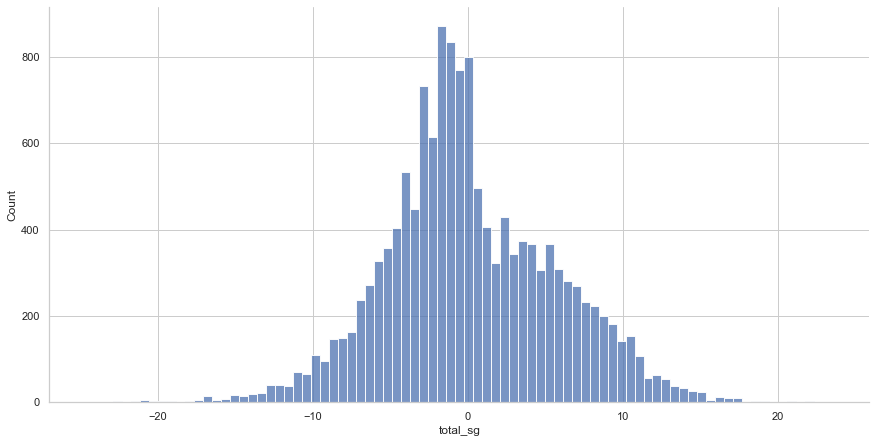

In [59]:
sns.histplot(data=event_df, x="total_sg")
sns.despine();

In [60]:
event_df[feat_cols + [target_col]].corr().loc[target_col]

early_out_in_prev_2_events    -0.166464
early_out_in_prev_5_events    -0.184910
fin_num_in_prev_2_events      -0.169571
fin_num_in_prev_5_events      -0.180553
mean_sg_in_prev_2_events       0.249279
mean_sg_in_prev_5_events       0.299423
won_major_in_prev_50_events    0.072989
top_10_in_prev_10_events       0.265026
top_10_in_prev_20_events       0.288985
close_odds                    -0.351907
total_sg                       1.000000
Name: total_sg, dtype: float64

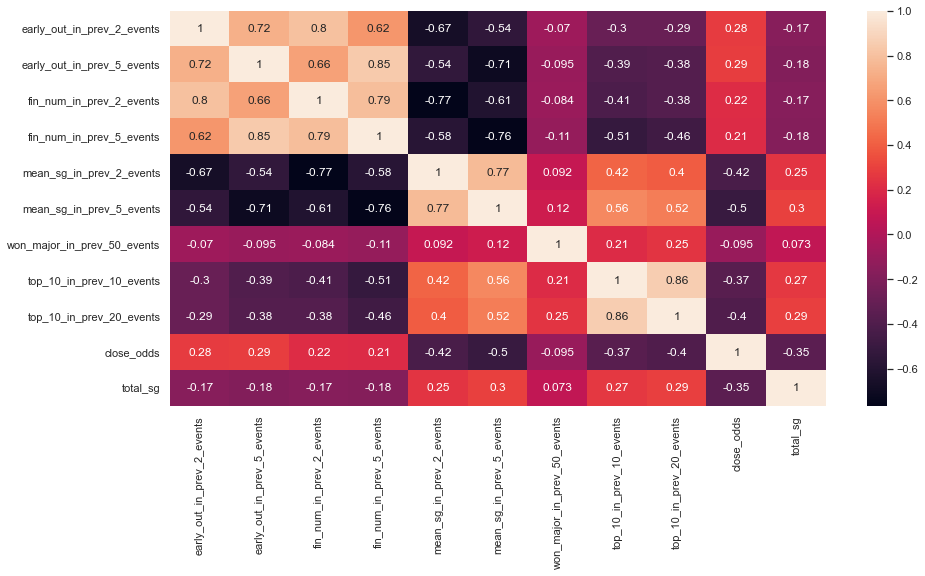

In [61]:
c = event_df[feat_cols + [target_col]].corr()
sns.heatmap(c, annot=True);

## Training

In [62]:
#Filtering out the first 10 events of the dataset
early_events_to_filter = event_df.sort_values('event_completed')['year_event_id'].unique()[0:11]
event_df = (event_df.loc[~event_df.year_event_id.isin(early_events_to_filter)]
            .reset_index(drop=True))

#splitting the data into independent (X) and dependent variables(y)
X = event_df[feat_cols]

y = event_df['total_sg']

### Fitting a Linear Regression Model

In [63]:
lr = OLS(y, X).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:               total_sg   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     237.1
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        22:07:24   Log-Likelihood:                -38662.
No. Observations:               12691   AIC:                         7.734e+04
Df Residuals:                   12681   BIC:                         7.742e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
early_out_in_prev_

#### Checking assumptions for a linear model:
    1. Must be linear in nature
    2. Residuals are normally distributed
    3. No Multicollinearity between predictors

In [67]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


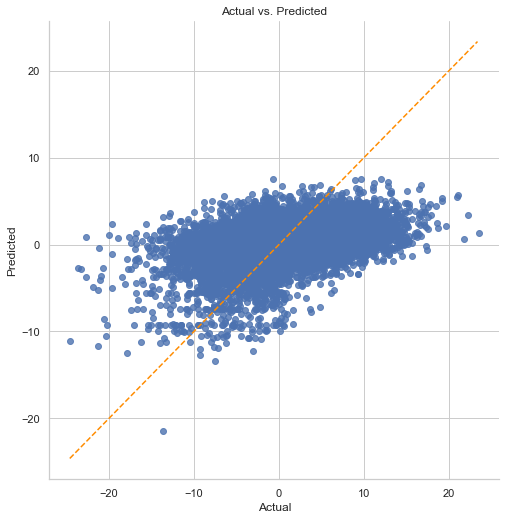

In [68]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
linear_assumption(lr, X, y);

There is far from a perfect linear relationship here

Assumption 2: The error terms are normally distributed 

p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


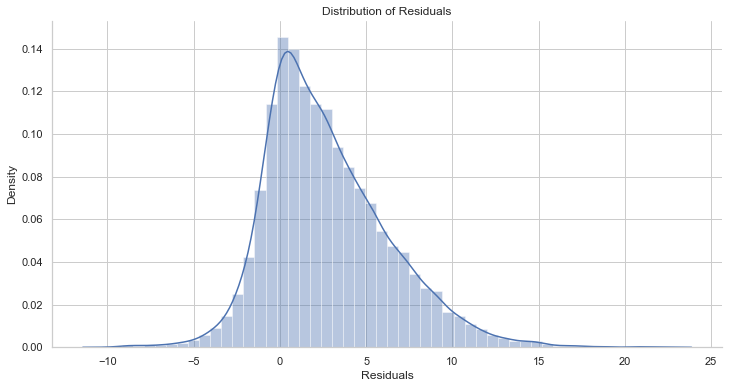


Assumption not satisfied


In [82]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    sns.despine()
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        
normal_errors_assumption(lr, X, y, p_value_thresh=0.05)

In [73]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        
multicollinearity_assumption(lr, X, y, feature_names=X.columns)

Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
early_out_in_prev_2_events: 11.010670288590925
early_out_in_prev_5_events: 19.146968378169095
fin_num_in_prev_2_events: 62.255281331579404
fin_num_in_prev_5_events: 69.86352118358097
mean_sg_in_prev_2_events: 6.2098038324327725
mean_sg_in_prev_5_events: 6.387024059044835
won_major_in_prev_50_events: 1.0872820421399465
top_10_in_prev_10_events: 6.214649531161044
top_10_in_prev_20_events: 6.73503516711157
close_odds: 1.9626654308806328

4 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic


## Fitting a Random Forest
Since the linear regression assumptions were not satisfied, moving on to a less demanding model

In [74]:
#Instantiate a Random Forest for Regression
rf = RandomForestRegressor(n_estimators=200, min_samples_split=2, max_depth=3)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#Fit the model
rf.fit(X_train, y_train)

#Make a prediction on the test data
preds = rf.predict(X_test)

mae = mean_absolute_error(y_test, preds).round(3)
print(f'Mean absolute error of {mae}')

Mean absolute error of 3.964


In [79]:
feat_imp_df = (pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
               .sort_values('importance')
              )

In [80]:
feat_imp_df

,feature,importance
0,early_out_in_prev_2_events,0.000000
6,won_major_in_prev_50_events,0.000046
1,early_out_in_prev_5_events,0.000119
7,top_10_in_prev_10_events,0.000425
2,fin_num_in_prev_2_events,0.000498
8,top_10_in_prev_20_events,0.001051
4,mean_sg_in_prev_2_events,0.002725
3,fin_num_in_prev_5_events,0.003279
5,mean_sg_in_prev_5_events,0.012676
9,close_odds,0.979181


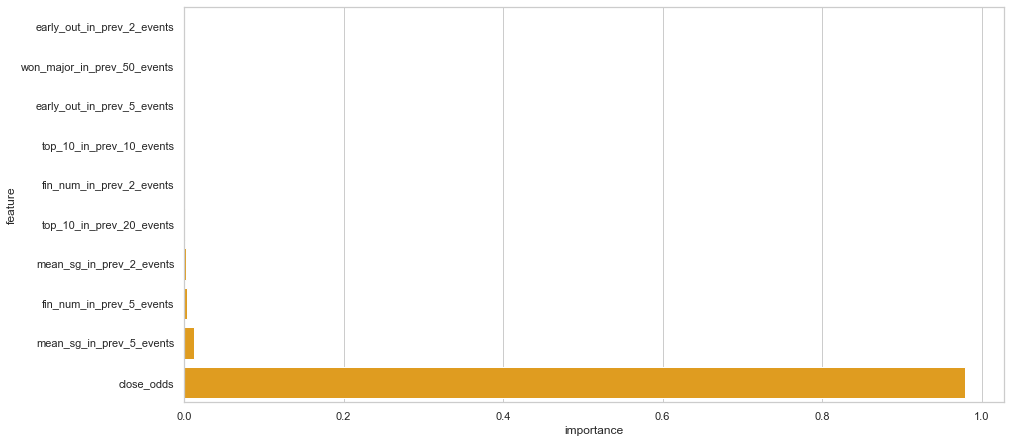

In [81]:
sns.barplot(x ='importance', y='feature', data=feat_imp_df, color='orange');

In [ ]:
#Save the RF model
pickle.dump(rf, open("../models/rf_model.pkl", "wb"))

#Write the event file for prediction on new data
event_df.to_csv('../data/historical_event_data.csv', index=False)